Importing libraries

In [1]:
import matplotlib.pyplot as plt
from glob import glob
import cv2
import random 
import os 
%matplotlib inline

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Input, Dropout, Flatten, Conv2D
from tensorflow.keras.layers import BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model

from IPython.display import SVG, Image
import tensorflow as tf

print('TF Version: ', tf.__version__)

TF Version:  2.13.0


Exporing Dataset

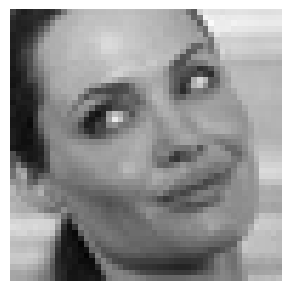

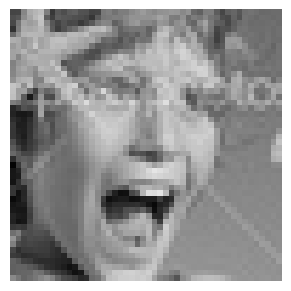

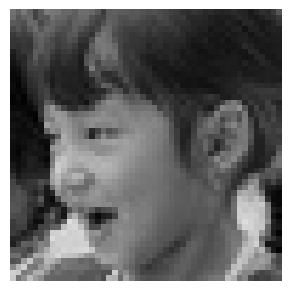

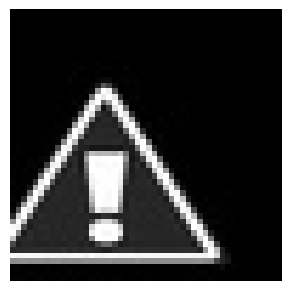

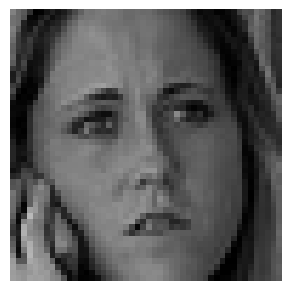

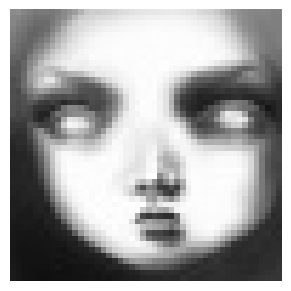

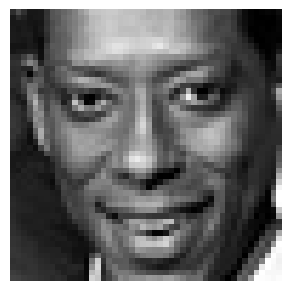

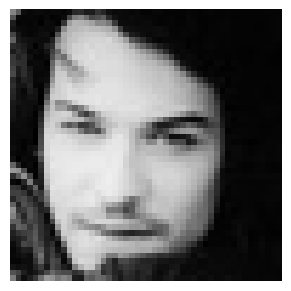

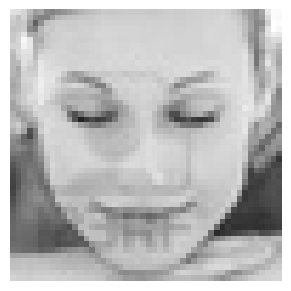

In [3]:
images = glob("train/**/**")
for i in range(9):
    image = random.choice(images)
    plt.figure(figsize=(12,12))
    plt.subplot(331+i)
    plt.imshow(cv2.imread(image));plt.axis('off')

Preparing data for training

In [4]:
img_size = 48
batch_size = 64
datagen_train = ImageDataGenerator()
train_gen = datagen_train.flow_from_directory("train/", target_size = (img_size, img_size),
                                                        color_mode = "grayscale",
                                                        batch_size = batch_size,
                                                        class_mode = "categorical",
                                                        shuffle = True)

validation_generator = datagen_train.flow_from_directory("test/", target_size = (img_size, img_size),
                                                        color_mode = "grayscale",
                                                        batch_size = batch_size,
                                                        class_mode = "categorical",
                                                        shuffle = True)


Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


Defining Model

In [5]:
def Convolution(input_tensor, filters, kernel_size):
    x = Conv2D(filters = filters, kernel_size = kernel_size, padding = "same")(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size = (2,2))(x)
    x = Dropout(0.25)(x)

    return x

In [6]:
def Dense_f(input_tensor, nodes):
    x = Dense(nodes)(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.25)(x)

    return x

In [7]:
def model_fer(input_shape):
    inputs = Input(input_shape)
    conv_1 = Convolution(inputs,32,(3,3))
    conv_2 = Convolution(inputs,64,(5,5))
    conv_3 = Convolution(inputs,128,(3,3))

    flatten = Flatten()(conv_3)

    dense_1 = Dense_f(flatten, 256)

    output = Dense(7, activation="softmax")(dense_1)
    model = Model(inputs= [inputs], outputs = [output])
    model.compile(loss = ['categorical_crossentropy'], optimizer = 'adam', metrics = ['accuracy'])

    return model

In [8]:
model = model_fer((48,48,1))
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 48, 1)]       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 48, 48, 128)       1280      
                                                                 
 batch_normalization_2 (Bat  (None, 48, 48, 128)       512       
 chNormalization)                                                
                                                                 
 activation_2 (Activation)   (None, 48, 48, 128)       0         
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 24, 24, 128)       0         
 g2D)                                                            
                                                                 
 dropout_2 (Dropout)         (None, 24, 24, 128)       0     

Initializing the Model

In [9]:
epochs = 15
steps_per_epoch = train_gen.n//train_gen.batch_size
validation_steps = validation_generator.n//validation_generator.batch_size

checkpoint = ModelCheckpoint("model_weights.h5", monitor = 'val_accuracy', save_weights_only=True, mode='max', verbose=1)
callbacks = [checkpoint]

Training the Model

In [10]:
history = model.fit(
    x = train_gen, 
    steps_per_epoch = steps_per_epoch,
    epochs = epochs,
    validation_data= validation_generator,
    validation_steps = validation_steps,
    callbacks = callbacks)

Epoch 1/15
448/448 [==============================] - ETA: 0s - loss: 1.6521 - accuracy: 0.3763
Epoch 1: saving model to model_weights.h5
448/448 [==============================] - 159s 353ms/step - loss: 1.6521 - accuracy: 0.3763 - val_loss: 1.6654 - val_accuracy: 0.3345
Epoch 2/15
448/448 [==============================] - ETA: 0s - loss: 1.3520 - accuracy: 0.4891
Epoch 2: saving model to model_weights.h5
448/448 [==============================] - 154s 343ms/step - loss: 1.3520 - accuracy: 0.4891 - val_loss: 1.4692 - val_accuracy: 0.4266
Epoch 3/15
448/448 [==============================] - ETA: 0s - loss: 1.1914 - accuracy: 0.5544
Epoch 3: saving model to model_weights.h5
448/448 [==============================] - 330s 737ms/step - loss: 1.1914 - accuracy: 0.5544 - val_loss: 1.4279 - val_accuracy: 0.4685
Epoch 4/15
448/448 [==============================] - ETA: 0s - loss: 1.0520 - accuracy: 0.6103
Epoch 4: saving model to model_weights.h5
448/448 [==============================] - 

Model Evaluation

In [11]:
model.evaluate(validation_generator)

113/113 [==============================] - 6s 57ms/step - loss: 2.3311 - accuracy: 0.4296


[2.3310773372650146, 0.4296461343765259]

Plotting Loss

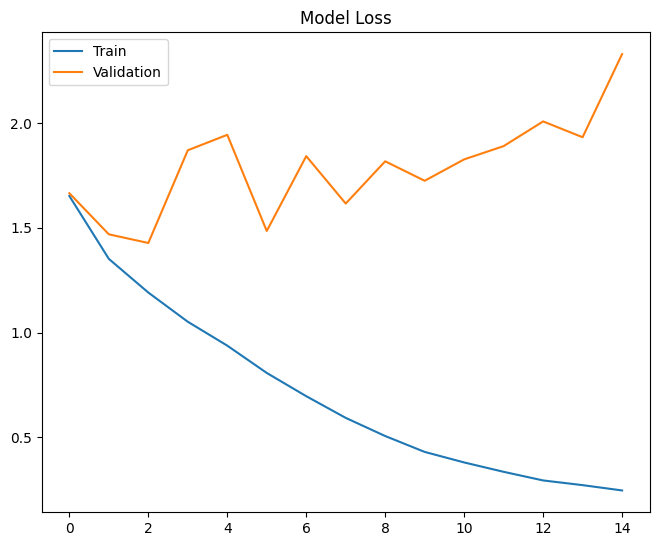

In [12]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.legend(['Train','Validation'], loc = 'upper left')
plt.subplots_adjust(top=1.0, bottom=0.0, right=0.95, left=0.0, hspace=0.25, wspace=0.35)

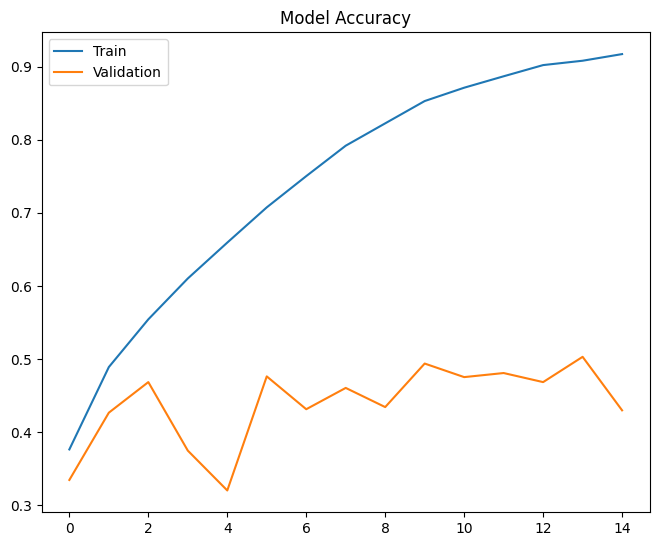

In [13]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.legend(['Train','Validation'], loc = 'upper left')
plt.subplots_adjust(top=1.0, bottom=0.0, right=0.95, left=0.0, hspace=0.25, wspace=0.35)

Saving Model

In [14]:
model_json = model.to_json()
with open("model_a.json","w") as json_file:
    json_file.write(model_json)